In [1]:
import argparse
from dataset import AGCDataset#, collate
from solver import Solver
from model import AGC_STFT_GRU
import torch
from torch.utils.data import DataLoader
import config
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

parser = config.parser
args= parser.parse_args("")

In [2]:
tt_dataset = AGCDataset(json_path = '/home/yhjeon/AGC/data/agc_1/valid.json', sample_rate=args.sample_rate, wav_len=args.wav_len, win_len=args.win_len, hop_len=args.hop_len)
tt_dataloader = DataLoader(tt_dataset, batch_size = 1, shuffle=True, num_workers = args.num_workers)

data = {'tt_loader': tt_dataloader}

model = AGC_STFT_GRU(480, 40, 480, 160)
    
package = torch.load('/home/yhjeon/AGC/src/agc_1/stft_gru_logmse.pth.tar')
model.load_state_dict(package['state_dict'])
model.cuda()
model.eval()

Processing 4901 of 5000
Done!


AGC_STFT_GRU(
  (relu): ReLU()
  (gru): GRU(241, 40, batch_first=True)
  (lin): Linear(in_features=40, out_features=1, bias=True)
  (upsample): Upsample(scale_factor=160.0, mode=linear)
)

elapsed time: 13.7ms
loss vs original: 0.00021100963931530714
loss vs distorted: 0.0002321511710761115


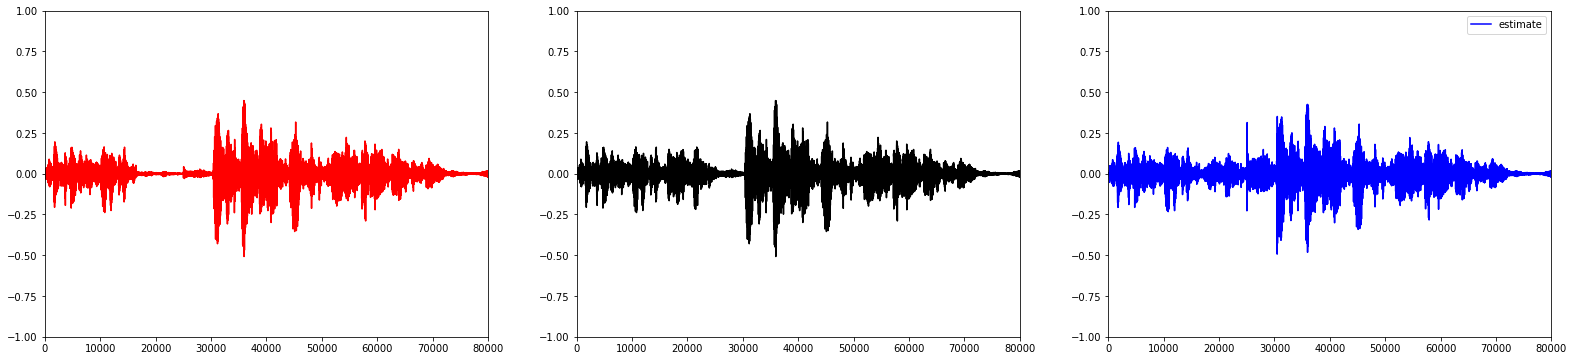

In [7]:
import time
import sounddevice as sd
import soundfile as sf

for i, data in enumerate(tt_dataloader):
    start = time.time()
    wav, gt = data['distorted'], data['original']
    wav = wav.cuda()
    gt = gt.cuda()
    start = time.time()
    est = model(wav)
    print('elapsed time:{0: .1f}ms'.format((time.time() - start) * 1000))
    criterion = torch.nn.MSELoss()
    loss = criterion(est, gt)
    loss2 = criterion(est, wav)
    
    est = est[0].cpu().detach().numpy()

    gt = gt[0].float().cpu()
    
    wav = wav[0].cpu()
    print('loss vs original: {}'.format(loss))
    print('loss vs distorted: {}'.format(loss2))
    
    plt.figure(figsize=[27, 6])
    plt.subplot(1, 3, 1)
    plt.axis([0, 80000, -1, 1])
    plt.plot(wav, color='red', label='distorted')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.axis([0, 80000, -1, 1])
    plt.plot(gt, color='black', label='original')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.axis([0, 80000, -1, 1])
    plt.plot(est, color='blue', label='estimate')
    plt.legend()
    plt.show()

    sf.write('wave_original.wav', data=gt, samplerate=16000)
    sf.write('wave_estimate.wav', data=est, samplerate=16000)
    sf.write('wave_distorted.wav', data=wav, samplerate=16000)
    break

elapsed time: 15.3ms


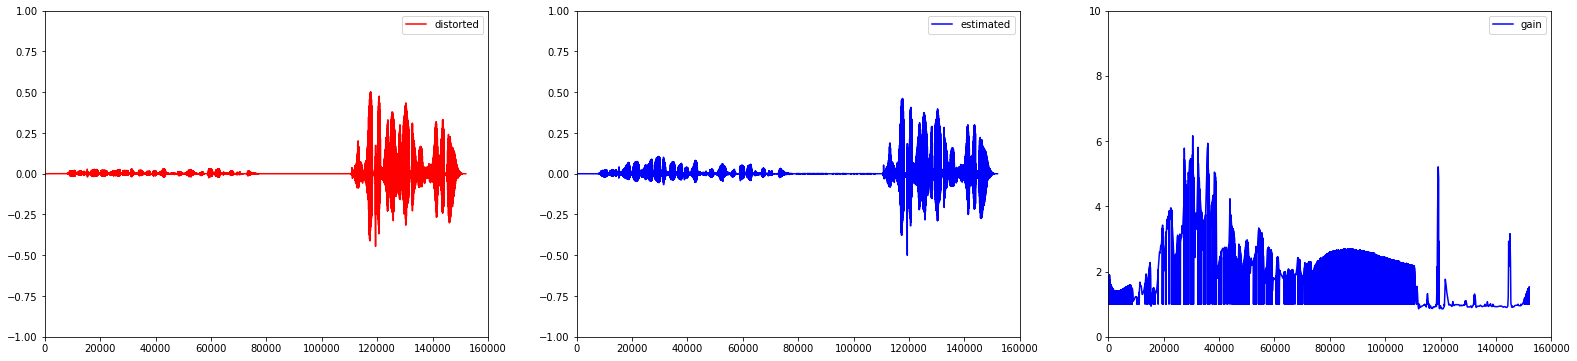

In [23]:
import numpy as np

for i in range(1):
    start = time.time()
    wav, _ = sf.read('/home/yhjeon/AGC/data/agc_1/female.wav')
    wav = np.concatenate([wav[80000:160000], wav[0:72000]])
    wav = torch.FloatTensor(wav[0:160000])
    wav = wav.unsqueeze(0)
    wav = wav.cuda()
    start = time.time()
    est = model(wav)
    print('elapsed time:{0: .1f}ms'.format((time.time() - start) * 1000))
    
    est = est[0].cpu().detach().numpy()
    wav = wav[0].cpu()

    gain = (est + 1e-8) / (wav + 1e-8)
    
    plt.figure(figsize=[27, 6])
    plt.subplot(1, 3, 1)
    plt.axis([0, 160000, -1, 1])
    plt.plot(wav, color='red', label='distorted')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.axis([0, 160000, -1, 1])
    plt.plot(est, color='blue', label='estimated')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.axis([0, 160000, 0, 10])
    plt.plot(gain, color='blue', label='gain')
    plt.legend()
    plt.show()

    #sf.write('/home/yhjeon/AGC/data/agc_1/female_enhanced.wav', data=est, samplerate=16000)
    break

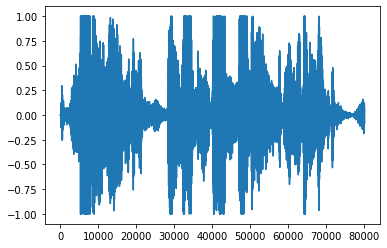

In [2]:
import soundfile as sf
import matplotlib.pyplot as plt
wav, _ = sf.read('/home/yhjeon/AGC/data/agc_2/train/original/agc_2_original_7.wav')
plt.plot(wav)
plt.show()